# Plot change in lidar snow depth for winter flights
---
*J. Michelle Hu  
University of Utah  
August 2024*  

In [1]:
import os
from pathlib import PurePath

import matplotlib.pyplot as plt
import numpy as np

import rasterio
import xarray as xr

In [2]:
# Grab snow depth 
def fn_list(thisDir, fn_pattern, verbose=False):
    """Match and sort filenames based on a regex pattern in specified directory

    Parameters
    -------------
    thisDir: str
        directory path to search
    fn_pattern: str
        regex pattern to match files
    verbose: boolean
        print filenames
    
    Returns
    -------------
    fns: list
        list of filenames matched and sorted
    """
    import glob
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    if verbose: print(fns)
    return fns


#### Get directories and filenames set up

In [3]:
work_dir = '/home/jovyan/shared-public/swesarr_project/'
nc_list = fn_list(work_dir, 'lidar/*nc') # these are the swe products that correspond to depth products, used for date grabbing
nc_list

['/home/jovyan/shared-public/swesarr_project//lidar/ASO_SWE_20200202_ROI.nc',
 '/home/jovyan/shared-public/swesarr_project//lidar/ASO_SWE_20200213_ROI.nc']

In [4]:
# Look at the images that Dylan uploaded

In [5]:
# radar_fns = fn_list(work_dir, '*radar/v3_tifs/*tif')
# radar_fns

In [6]:
# %%time
# radar_list = [np.squeeze(xr.open_dataset(rfn)) for rfn in radar_fns]
# for jdx, backscatter in enumerate(radar_list):
#     # break
#     fig, ax = plt.subplots()
#     backscatter['band_data'].plot.imshow(ax=ax)
#     if jdx > 3:
#         break
# # del radar_list

In [7]:
# xr.open_dataset(radar_fns[0])

In [8]:
# import xarray as xr

In [9]:
# sd_list = [xr.open_dataset(nc_fn) for nc_fn in ]

In [10]:
# sd_list[0]

In [11]:
import geopandas as gpd

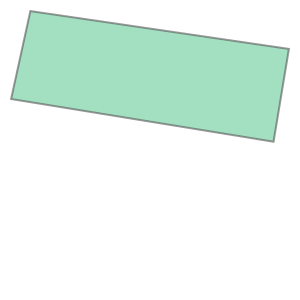

In [12]:
roi_fn = "/home/jovyan/shared-public/swesarr_project/swesarr-roi/swesarr-roi.shp"
poly = gpd.read_file(roi_fn)
poly['name'] = ['swesarr_bbox']
poly_32613 = poly.to_crs(epsg=32613)
poly_32613.geometry[0]

In [13]:
for f in poly.geometry:
    print(f)

POLYGON ((-108.21570641810067 39.023945943313166, -108.19531884215058 39.0221881018874, -108.19626765553384 39.01647660780745, -108.2169736520879 39.01852388325856, -108.21570641810067 39.023945943313166))


## Pull snow depth from snowex database

In [14]:
%%time
# import in the raster measurements class
from snowexsql.api import RasterMeasurements #pip install snowexsql
from datetime import datetime 
from rasterio.plot import show

# Pick the dates (can also find them from the filter unique example)
dt_list = [datetime(2020, 2, 2), datetime(2020, 2, 13)]

# Query db filtering to swe on a certain date surveyed by ASO
ds_list = [RasterMeasurements.from_filter(observers='ASO Inc.', date=dt, type='depth') for dt in dt_list]

# Note the resolution!
[ds[0].res for ds in ds_list]

CPU times: user 1.38 s, sys: 906 ms, total: 2.29 s
Wall time: 46.7 s


[(3.000000000007304, 3.000000000007304),
 (3.000000000007304, 3.000000000007304)]

In [15]:
# pull transforms for plotting and localized writing
transforms = [ds[0].transform for ds in ds_list]
depth_arrays = [ds[0].read() for ds in ds_list]
profiles = [ds[0].profile for ds in ds_list]

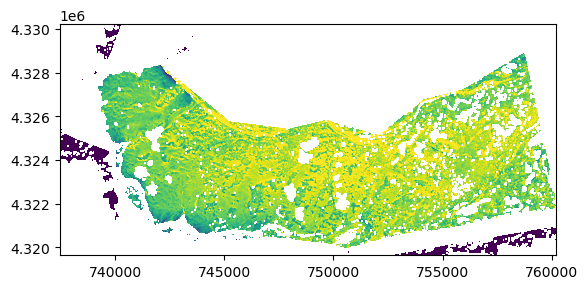

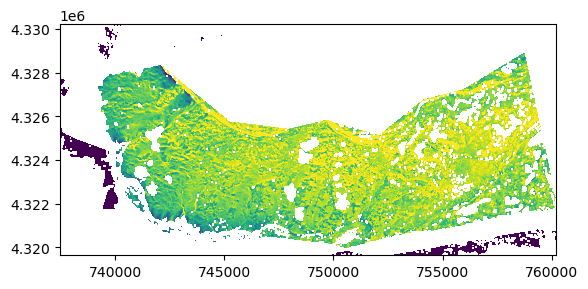

In [16]:
for depth, transform in zip(depth_arrays, transforms):
    depth = np.squeeze(depth)
    show(depth, transform=transform, vmin=0, vmax=np.nanpercentile(depth, 84))

In [17]:
%%time
depth_diff = depth_arrays[1] - depth_arrays[0]

CPU times: user 24.7 ms, sys: 16.2 ms, total: 40.9 ms
Wall time: 39.6 ms


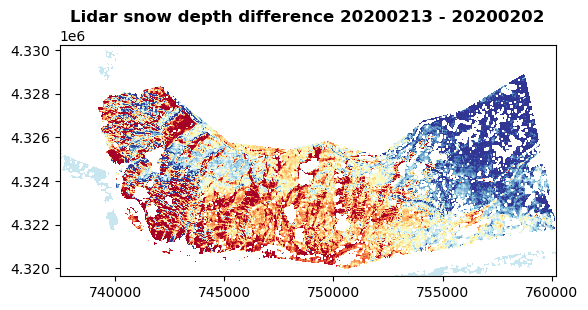

In [18]:
p = 16
vmin = np.nanpercentile(depth_diff, p)
vmax = np.nanpercentile(depth_diff, 100-p)
cmap = 'RdYlBu'
title = 'Lidar snow depth difference 20200213 - 20200202'
show(depth_diff, transform=transform, vmin=vmin, vmax=vmax, cmap='RdYlBu', title=title);

## Write it out for posterity

In [19]:
# Remind yourself of dates again
for nc in nc_list:
    print(PurePath(nc).stem)

ASO_SWE_20200202_ROI
ASO_SWE_20200213_ROI


In [20]:
outname = 'GM_lidar_snowdepth_diff_20200213_20200202.tif'
if not os.path.exists(outname):
    with rasterio.Env():
        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = profiles[0]
    
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw')
    
        with rasterio.open(outname, 'w', **profile) as dst:
            dst.write(depth_diff)

# read it back in to check
test = np.squeeze(xr.open_dataset(outname))
test

<xarray.Dataset>
Dimensions:      (x: 7576, y: 3528)
Coordinates:
    band         int64 1
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

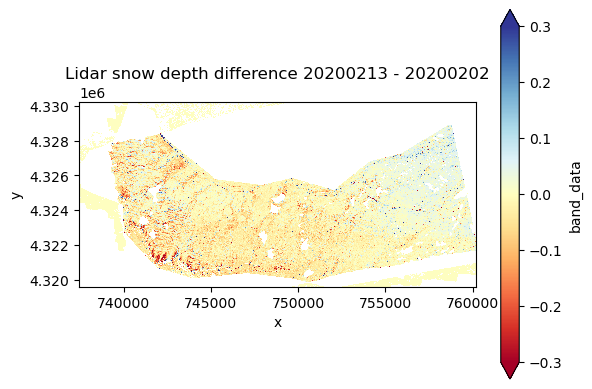

In [21]:
fig, ax = plt.subplots()
test['band_data'].plot.imshow(vmin=-0.3, vmax=0.3, ax=ax, cmap=cmap)
ax.set_aspect('equal')
ax.set_title(title);

### Crop to ROI!

EPSG:26912


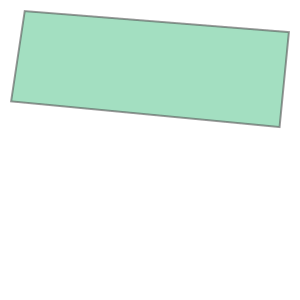

In [22]:
crs = profiles[0]['crs']
print(crs)
poly_reproj = poly.to_crs(crs=crs)
poly_reproj.geometry[0]

In [23]:
clipped = test.rio.clip(poly_reproj.geometry)
clipped

<xarray.Dataset>
Dimensions:      (x: 621, y: 259)
Coordinates:
    band         int64 1
  * x            (x) float64 7.409e+05 7.409e+05 ... 7.428e+05 7.428e+05
  * y            (y) float64 4.323e+06 4.323e+06 ... 4.322e+06 4.322e+06
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

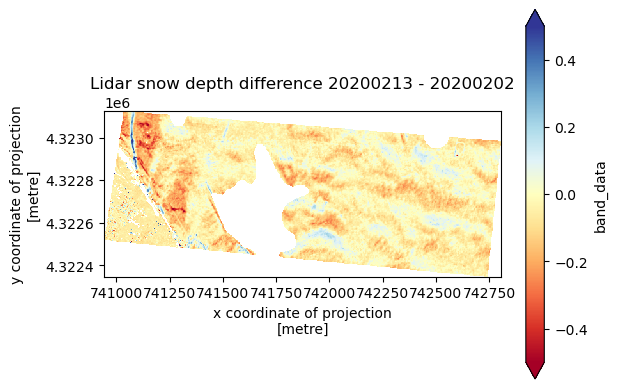

In [24]:
# vmin = np.nanpercentile(clipped['band_data'].values, p)
# vmax = np.nanpercentile(clipped['band_data'].values, 100-p)
fig, ax = plt.subplots()
clipped['band_data'].plot.imshow(vmin=-0.5, vmax=0.5, ax=ax, cmap=cmap)
ax.set_aspect('equal')
ax.set_title(title);

## Write out the depths for posterity as well

In [25]:
outname = 'GM_SWESARR_ROI_lidar_snowdepth_diff_20200213_20200202.tif'
if not os.path.exists(outname):
    with rasterio.Env():
        profile = profiles[0]
    
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw')
    
        with rasterio.open(outname, 'w', **profile) as dst:
            dst.write(depth_diff)

# read it back in to check
test = np.squeeze(xr.open_dataset(outname))
test

<xarray.Dataset>
Dimensions:      (x: 7576, y: 3528)
Coordinates:
    band         int64 1
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...